<a href="https://colab.research.google.com/github/marcinwolter/Higgs_Janka/blob/main/Higgs_Janka_5v_PNN%2BNN-abs_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higgs analysis of Janka

author: Marcin Wolter, February 2021

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

'''
! pip install tensorflow==2.4.0
! pip install pandas
! pip install sklearn
! pip install keras
'''

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Read the cvs input data from google disk and create DataFrame

IMPORTANT: from background only a part of events is read (we read an equal number of signal and background events)

In [ ]:
# Read csv data

from google.colab import drive
drive.mount('/content/drive')

masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]
#masses = [200, 250, 300, 350, 400, 500, 600, 700, 2500]

bckg = []
sig = []
for i in range(len(masses)):
  bckg_str = '/content/drive/MyDrive/jkrzysiak/data_full/Ztautau_'+str(masses[i])+'GeV.csv'
  bckg.append(pd.read_csv(bckg_str) )
  sig_str = '/content/drive/MyDrive/jkrzysiak/data_full/signal_'+str(masses[i])+'GeV.csv'
  sig.append(pd.read_csv(sig_str) )


#print(bckg)

XX = []
YY = []
WEIGHT = []

for i in range(len(masses)):
  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'signal_mass']]
###  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'lep_pt', 'MET',	'tau_phi-lep_phi',	'tau_phi-MET_phi', 'tau_eta',	'lep_eta', 'signal_mass']]
###  xs = sig[i][['MTtot',  'signal_mass']]
  xsw= sig[i][['weight']]
  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'signal_mass']] #.head(5*len(xs))
###  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'lep_pt', 'MET',	'tau_phi-lep_phi',	'tau_phi-MET_phi', 'tau_eta',	'lep_eta', 'signal_mass']] #.head(5*len(xs))
###  xb = bckg[i][['MTtot',  'signal_mass']] #.head(5*len(xs))
  xbw= bckg[i][['weight']] #.head(5*len(xs))
  
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["vClass"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["vClass"])

  # WARNING: take absolute values of weights!!!
  xsw = xsw.abs()
  xbw = xbw.abs()

  sum_sw = xsw.sum()
  sum_bw = xbw.sum()
  xsw = xsw.mul(sum_bw/sum_sw)

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  print(x.shape, y.shape, w.shape)



Mounted at /content/drive
(1414396, 5) (1414396, 1) (1414396, 1)
(1425476, 5) (1425476, 1) (1425476, 1)
(1446300, 5) (1446300, 1) (1446300, 1)
(1461095, 5) (1461095, 1) (1461095, 1)
(1471361, 5) (1471361, 1) (1471361, 1)
(1483219, 5) (1483219, 1) (1483219, 1)
(1448090, 5) (1448090, 1) (1448090, 1)
(1447411, 5) (1447411, 1) (1447411, 1)
(1445797, 5) (1445797, 1) (1445797, 1)
(1414950, 5) (1414950, 1) (1414950, 1)
(1395065, 5) (1395065, 1) (1395065, 1)
(1384146, 5) (1384146, 1) (1384146, 1)
(1375814, 5) (1375814, 1) (1375814, 1)


Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 




In [ ]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=0.50, shuffle=True, random_state=42)



(18613120, 5) (18613120, 1) (18613120, 1)


In [ ]:
# Define normalization of input data
layer = preprocessing.Normalization()
layer.adapt(x_train_all.to_numpy())

Prepare a small fully connected network

In [ ]:
# prepare keras model

def define_model():
  n_nodes = 256 #16 #128
  dropout = 0.01
  ###dropout = 0.08
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_shape=(5,)))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [ ]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")

  '''
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=False)
  '''  
  def lr_schedule(epoch, lr):
    decay_rate = 0.90
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        #return lr * pow(decay_rate, np.floor(epoch / decay_step))
        return lr * decay_rate
    return lr
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #learning_rate=lr_schedule)

  def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
  lr_metric = get_lr_metric(optimizer) 

  #metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', # 'mse'  'binary_crossentropy'
              optimizer=optimizer, #"sgd",
              metrics=[tf.keras.metrics.AUC(name='auc'),lr_metric])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=16,
    verbose=1,
    restore_best_weights=True
  )

  callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

  epochs = 100
  #epochs = 1
  batch_size=128
  
  print("fitting")
  history = model.fit(x_train, y_train, 
                    sample_weight=sw_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val, sw_val),
                    callbacks=[es,callback])




  return history, model
#sample_weight = sw_train,

K-folding

In [ ]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("fit_model")
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    loss, auc, _  = model.evaluate(testX, testY, verbose=0)
    print(loss, auc)
		# stores scores
    scores.append(loss)
    histories.append(history)
    models.append(model)

    #save model
    aux = '/content/drive/MyDrive/jkrzysiak/modelfull'+str(len(models)-1)+'.h5'
    model.save(aux)

    # break the loop to avoid k-folding
    break

  return scores, histories, models

Plot learning curves and summary of training

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification AUC')
    plt.plot(histories[i].history['auc'], color='blue', label='train')
    plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [ ]:
def network_fit(np_x_train_all, np_y_train_all, np_sw_train_all):


  #convert to numpy

  np_x_train_all = np_x_train_all.to_numpy()
  np_y_train_all = np_y_train_all.to_numpy()
  np_sw_train_all = np_sw_train_all.to_numpy()


  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  np_x_train_all = np.array(layer(np_x_train_all))

  # Train the network. 
  n_folds = 100  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [ ]:
# train the network
scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

fit_model
compiling
fitting
Epoch 1/100
71981/71981 [==============================] - 264s 4ms/step - loss: 0.0650 - auc: 0.6881 - lr: 9.9996e-05 - val_loss: 0.0466 - val_auc: 0.7936 - val_lr: 1.0000e-04
Epoch 2/100
71981/71981 [==============================] - 250s 3ms/step - loss: 0.0456 - auc: 0.7966 - lr: 8.9984e-05 - val_loss: 0.0412 - val_auc: 0.7998 - val_lr: 9.0000e-05
Epoch 3/100
71981/71981 [==============================] - 246s 3ms/step - loss: 0.0445 - auc: 0.7960 - lr: 8.1006e-05 - val_loss: 0.0414 - val_auc: 0.8008 - val_lr: 8.1000e-05
Epoch 4/100
71981/71981 [==============================] - 250s 3ms/step - loss: 0.0439 - auc: 0.7991 - lr: 7.2926e-05 - val_loss: 0.0399 - val_auc: 0.8024 - val_lr: 7.2900e-05
Epoch 5/100
71981/71981 [==============================] - 250s 3ms/step - loss: 0.0430 - auc: 0.7992 - lr: 6.5597e-05 - val_loss: 0.0405 - val_auc: 0.7863 - val_lr: 6.5610e-05
Epoch 6/100
71981/71981 [==============================] - 248s 3ms/step - loss: 0.0428

Make plots

dict_keys(['loss', 'auc', 'lr', 'val_loss', 'val_auc', 'val_lr'])


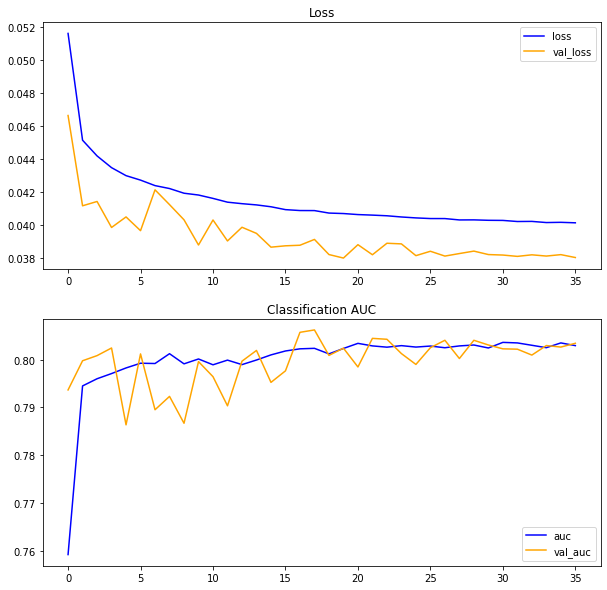

Accuracy: mean=215.759 std=0.000, n=1


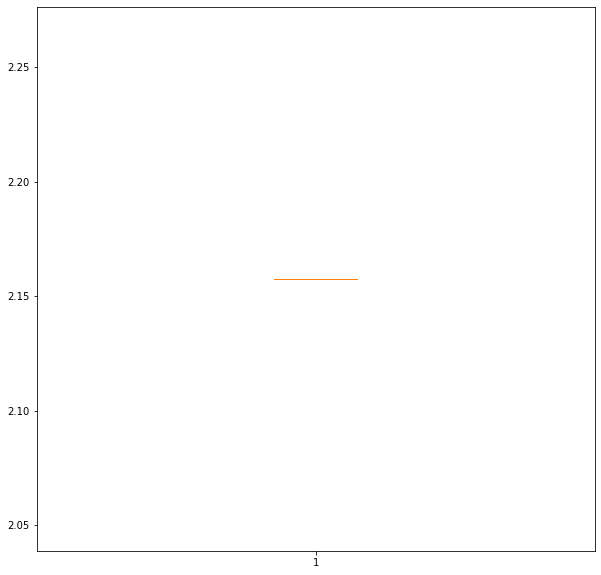

Scores:  [2.157592535018921]


In [ ]:
# learning curves
print(histories[0].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Load saved model

In [ ]:
#load model

def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)

aux = '/content/drive/MyDrive/jkrzysiak/modelfull'+str(0)+'_abs_backup.h5'
models = []
model=tf.keras.models.load_model(aux, custom_objects={'lr':lr})
models.append(model)
len(models)


"\ndef lr(y_true, y_pred):\n        return optimizer._decayed_lr(tf.float32)\n\naux = '/content/drive/MyDrive/jkrzysiak/modelfull'+str(0)+'_backup.h5'\nmodels = []\nmodel=tf.keras.models.load_model(aux, custom_objects={'lr':lr})\nmodels.append(model)\nlen(models)\n"

Find the roc curve

In [ ]:
def binary_clf_curve(y_true, y_score, pos_label=None, sample_weight=None):
    """Calculate true and false positives per binary classification threshold.
    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        True targets of binary classification.
    y_score : ndarray of shape (n_samples,)
        Estimated probabilities or output of a decision function.
    pos_label : int or str, default=None
        The label of the positive class.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    Returns
    -------
    fps : ndarray of shape (n_thresholds,)
        A count of false positives, at index i being the number of negative
        samples assigned a score >= thresholds[i]. The total number of
        negative samples is equal to fps[-1] (thus true negatives are given by
        fps[-1] - fps).
    tps : ndarray of shape (n_thresholds,)
        An increasing count of true positives, at index i being the number
        of positive samples assigned a score >= thresholds[i]. The total
        number of positive samples is equal to tps[-1] (thus false negatives
        are given by tps[-1] - tps).
    thresholds : ndarray of shape (n_thresholds,)
        Decreasing score values.
    """
    # MWMW !!!!!!!!!!!!!!!!
    # replace all negative weights with 0
    #sample_weight[sample_weight<0] = 0


    # make y_true a boolean vector
    y_true = (y_true == 1)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    if sample_weight is not None:
        weight = sample_weight[desc_score_indices]
    else:
        weight = 1.

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    #print weights < 0
    #for i in range(0,len(weight)):
    #  if weight[i]<0:
    #    print("Neg.weight ",i,"  ",weight[i])

    # accumulate the true positives with decreasing threshold
    #from sklearn.utils.extmath import stable_cumsum
    #tps = stable_cumsum(y_true * weight)[threshold_idxs]
    tps = np.cumsum(y_true * weight)[threshold_idxs]
    if sample_weight is not None:
        # express fps as a cumsum to ensure fps is increasing even in
        # the presence of floating point errors
        #fps = stable_cumsum((1 - y_true) * weight)[threshold_idxs]
        fps = np.cumsum((1 - y_true) * weight)[threshold_idxs]
    else:
        fps = 1 + threshold_idxs - tps
  
    # Add an extra threshold position
    # to make sure that the curve starts at (0, 0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    threshold_idxs = np.r_[threshold_idxs[0] + 1, threshold_idxs]

    return fps/fps[-1], tps/tps[-1], y_score[threshold_idxs]

Calculate AUC

In [ ]:
def getAuc(x, y):
    """Compute Area Under the Curve (AUC) using the trapezoidal rule.
    This is a general function, given points on a curve.  For computing the
    area under the ROC-curve, see :func:`roc_auc_score`.  For an alternative
    way to summarize a precision-recall curve, see
    :func:`average_precision_score`.
    Parameters
    ----------
    x : ndarray of shape (n,)
        x coordinates. These must be either monotonic increasing or monotonic
        decreasing.
    y : ndarray of shape, (n,)
        y coordinates.
    Returns
    -------
    auc : float
    See Also
    --------
    roc_auc_score : Compute the area under the ROC curve.
    average_precision_score : Compute average precision from prediction scores.
    precision_recall_curve : Compute precision-recall pairs for different
        probability thresholds.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn import metrics
    >>> y = np.array([1, 1, 2, 2])
    >>> pred = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    >>> metrics.auc(fpr, tpr)
    0.75
    """
    from sklearn.utils import check_consistent_length
    from sklearn.utils import column_or_1d, check_array
    from decimal import Decimal



    check_consistent_length(x, y)
    x = column_or_1d(x)
    y = column_or_1d(y)

    if x.shape[0] < 2:
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % x.shape)

    direction = 1
    dx = np.diff(x)

    if np.count_nonzero(dx>=0) < np.count_nonzero(dx<=0):
      direction = -1

    # remove elements with diff<=0 
    #x=np.delete(x,np.nonzero(direction*dx <= 0))
    #y=np.delete(y,np.nonzero(direction*dx <= 0))
    #dx=np.delete(dx,np.nonzero(direction*dx <= 0))  
    #print("dx<0 indices are ", np.nonzero(dx <= 0),np.array((np.nonzero(dx <= 0))).shape,dx[dx<=0]) 

    area = direction * np.trapz(y, x)
    print("getAuc area & max(y): ",area,np.max(y))
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in np.trapz do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area

Build an ensamble of networks trained using k-folding and test it on test data

---



In [ ]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #Limit the number of events
  #n_events = 100000
  #x_test_all, y_test_all, sw_test_all = x_test_all[0:n_events], y_test_all[0:n_events], sw_test_all[0:n_events]


  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  np_y_test_all = y_test_all.to_numpy()
  np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()



  # normalize test data
  np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  # replace negative values by zero
  #summed[summed<0] = 0
  #summed_s[summed_s<0] = 0
  #summed_b[summed_b<0] = 0
  
  # func to calculate auc

  #fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all, drop_intermediate=False)
  fpr, tpr, tresholds = binary_clf_curve(np_y_test_all, summed, sample_weight=np_sw_test_all)

  print("Number of ROC thresholds: ", tresholds.shape)
  r_auc = getAuc(fpr,tpr)
  print('auc = ',r_auc)


  #m = tf.keras.metrics.AUC(num_thresholds=1000)
  #m.update_state(np_y_test_all, summed, sample_weight=np_sw_test_all)
  #r_auc = m.result().numpy()
  #print("r_auc (ensamble) == ",r_auc)

  aucs = []
  for i in range(len(models)):
    yyhats = models[i].predict(np_x_test_all)[:,0]
    #m.update_state(np_y_test_all, yyhats, sample_weight=np_sw_test_all)
    #aucs.append(m.result().numpy())
    #fpr, tpr, tresholds = roc_curve(np_y_test_all, yyhats, sample_weight=np_sw_test_all, drop_intermediate=True)
    fpr, tpr, tresholds = binary_clf_curve(np_y_test_all, yyhats, sample_weight=np_sw_test_all)

    aucs.append(getAuc(fpr,tpr))


  av_auc = np.mean(aucs)

  

  #plot roc
  plt.figure(figsize=(6,4))
  plt.plot(1-fpr[tpr>0.99],tpr[tpr>0.99])
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  summed = summed.reshape((len(summed),1))
  summed_s = summed_s.reshape((len(summed_s),1))
  summed_b = summed_b.reshape((len(summed_b),1))

  
  plt.figure(figsize=(6,4))
  plt.hist(summed_s, weights=np_sw_test_all_s, bins=200, label="Signal",log=False, alpha=0.5, histtype='stepfilled')  
  plt.hist(summed_b, weights=np_sw_test_all_b, bins=200, label="Bckg.",log=False, alpha=0.5, histtype='stepfilled')
  plt.ylim(bottom=0)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  return r_auc, av_auc, aucs

Test accuracy

In [ ]:
def accuracy_ensamble(x_test_all, y_test_all, sw_test_all):

  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  #np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  #np_y_test_all = y_test_all.to_numpy()
  #np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()

  np_sw_test_all_s = np_sw_test_all_s.reshape((len(np_sw_test_all_s)))
  np_sw_test_all_b = np_sw_test_all_b.reshape((len(np_sw_test_all_b)))

  # normalize test data
  #np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  #yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  #summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  cut=0.5
  summed_s[summed_s>cut] = 1
  summed_s[summed_s<cut] = 0
  summed_b[summed_b>cut] = 1
  summed_b[summed_b<cut] = 0

  isummed_s = summed_s.astype(np.int32)
  isummed_b = summed_b.astype(np.int32)


  false_neg, true_pos = np.bincount(isummed_s, weights=np_sw_test_all_s)
  #false_neg=np.bincount((1-isummed_s), weights=np_sw_test_all_s)
  true_neg, false_pos = np.bincount(isummed_b, weights=np_sw_test_all_b)
  #false_pos=np.bincount((1-isummed_b), weights=np_sw_test_all_b)

  #print("true_pos = ",true_pos)
  #print("false_neg = ",false_neg)
  #print("true_neg = ",true_neg)
  #print("false_pos = ",false_pos)

  sensitivity = true_pos / (true_pos+false_neg)
  specificity = true_neg / (true_neg+false_pos)
  accuracy    = (true_pos + true_neg)/(true_pos + true_neg + false_neg + false_pos)

  print("accuracy = ",accuracy,", specificity = ", specificity,", sensitivity = ", sensitivity)

  return accuracy, specificity, sensitivity

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200
Number of ROC thresholds:  (589876,)
getAuc area & max(y):  0.961572241528892 1.0
auc =  0.961572241528892
getAuc area & max(y):  0.961572241528892 1.0


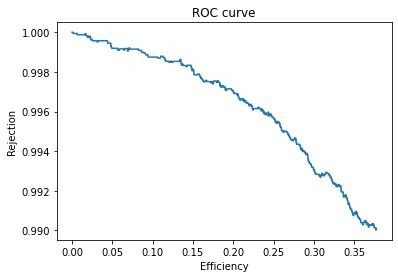

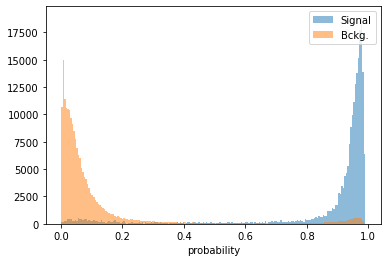

accuracy =  0.9260879438221516 , specificity =  0.9353011982435706 , sensitivity =  0.9170374665506966
-------------------------------------------
signal_mass =  250
Number of ROC thresholds:  (604342,)
getAuc area & max(y):  0.9795783057508234 1.0
auc =  0.9795783057508234
getAuc area & max(y):  0.9795783057508234 1.0


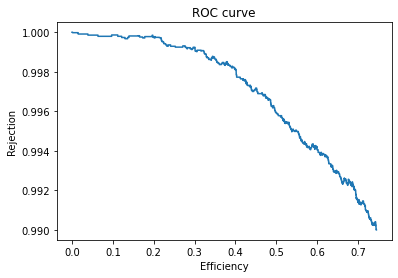

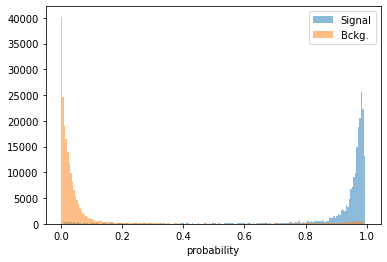

accuracy =  0.9514105205081884 , specificity =  0.9442271240495075 , sensitivity =  0.9586180450813704
-------------------------------------------
signal_mass =  300
Number of ROC thresholds:  (619532,)
getAuc area & max(y):  0.9873329526505629 1.0000637967776436
auc =  0.9873329526505629
getAuc area & max(y):  0.9873329526505629 1.0000637967776436


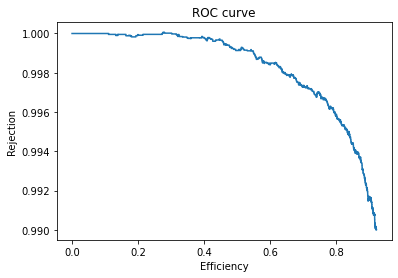

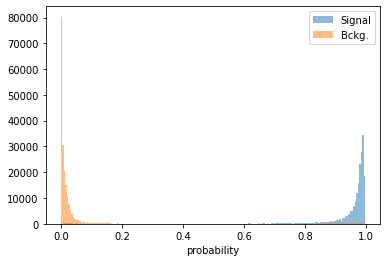

accuracy =  0.9634636707842569 , specificity =  0.9495511516416052 , sensitivity =  0.9774464507743323
-------------------------------------------
signal_mass =  350
Number of ROC thresholds:  (625387,)
getAuc area & max(y):  0.990445939352783 1.0
auc =  0.990445939352783
getAuc area & max(y):  0.990445939352783 1.0


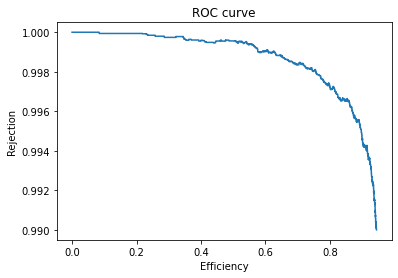

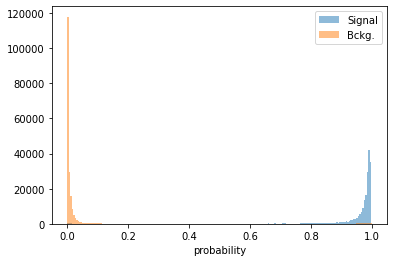

accuracy =  0.9696077788134256 , specificity =  0.9553945788017286 , sensitivity =  0.9837726959353592
-------------------------------------------
signal_mass =  400
Number of ROC thresholds:  (623597,)
getAuc area & max(y):  0.9928213039248015 1.0000285353081741
auc =  0.9928213039248015
getAuc area & max(y):  0.9928213039248015 1.0000285353081741


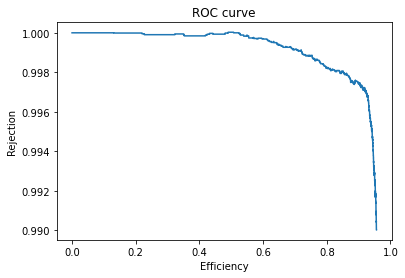

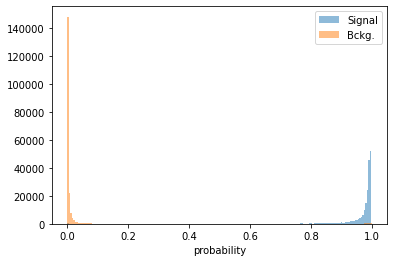

accuracy =  0.9730029622720489 , specificity =  0.9603964176408383 , sensitivity =  0.98571943932896
-------------------------------------------
signal_mass =  500
Number of ROC thresholds:  (600657,)
getAuc area & max(y):  0.9958203769386885 1.0
auc =  0.9958203769386885
getAuc area & max(y):  0.9958203769386885 1.0


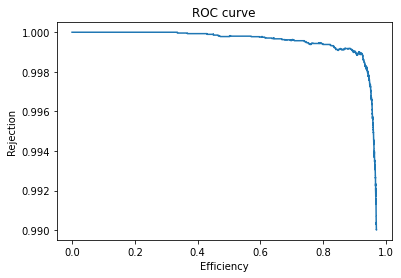

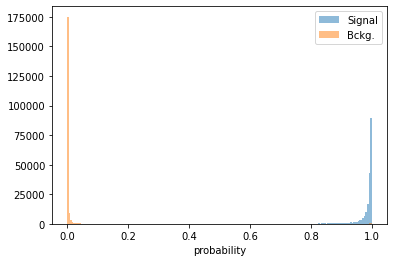

accuracy =  0.9798431480242787 , specificity =  0.9697907360281757 , sensitivity =  0.9898353098187498
-------------------------------------------
signal_mass =  600
Number of ROC thresholds:  (560186,)
getAuc area & max(y):  0.9973254700202259 1.0000306306705775
auc =  0.9973254700202259
getAuc area & max(y):  0.9973254700202259 1.0000306306705775


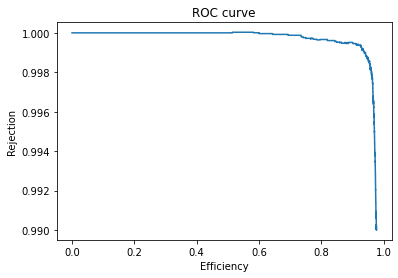

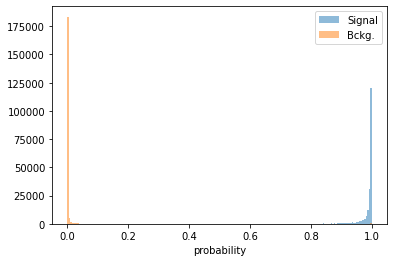

accuracy =  0.9835363026375475 , specificity =  0.9761990291864706 , sensitivity =  0.9907822588041446
-------------------------------------------
signal_mass =  700
Number of ROC thresholds:  (520989,)
getAuc area & max(y):  0.9981149022636319 1.0
auc =  0.9981149022636319
getAuc area & max(y):  0.9981149022636319 1.0


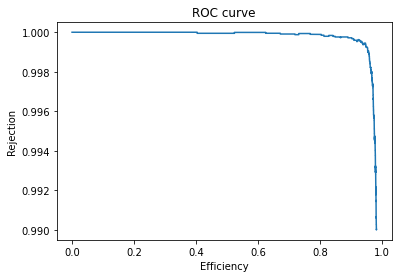

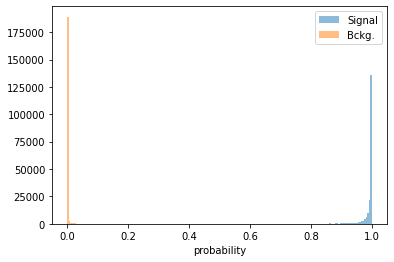

accuracy =  0.9858393726223296 , specificity =  0.9809288403894658 , sensitivity =  0.9907893006303723
-------------------------------------------
signal_mass =  800
Number of ROC thresholds:  (482009,)
getAuc area & max(y):  0.9986383736945112 1.0
auc =  0.9986383736945112
getAuc area & max(y):  0.9986383736945112 1.0


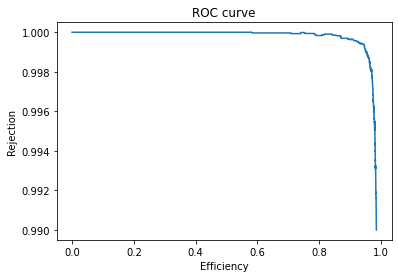

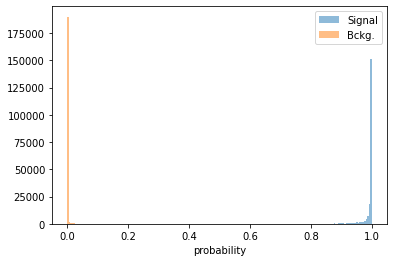

accuracy =  0.9877278605472056 , specificity =  0.983852447883593 , sensitivity =  0.9915837813461006
-------------------------------------------
signal_mass =  1200
Number of ROC thresholds:  (401558,)
getAuc area & max(y):  0.9995054092717449 1.0
auc =  0.9995054092717449
getAuc area & max(y):  0.9995054092717449 1.0


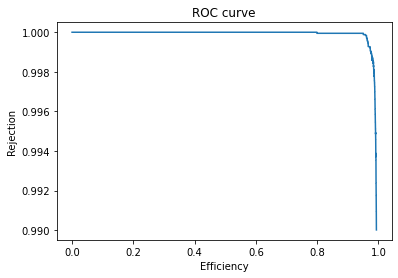

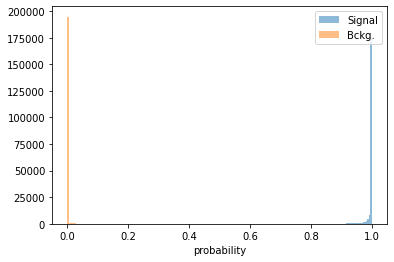

accuracy =  0.9928847931639704 , specificity =  0.9909453730152182 , sensitivity =  0.9948164415682554
-------------------------------------------
signal_mass =  1500
Number of ROC thresholds:  (374272,)
getAuc area & max(y):  0.9997994597737255 1.0001069950161365
auc =  0.9997994597737255
getAuc area & max(y):  0.9997994597737255 1.0001069950161365


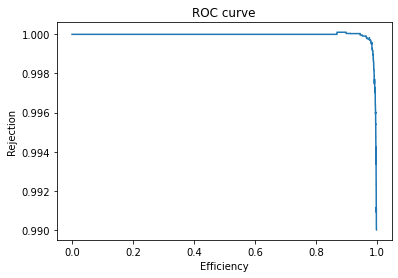

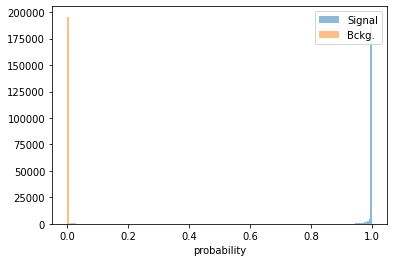

accuracy =  0.9951326302581958 , specificity =  0.9940828112214661 , sensitivity =  0.9961703470140458
-------------------------------------------
signal_mass =  2000
Number of ROC thresholds:  (357058,)
getAuc area & max(y):  0.9999240686179696 1.000056588655858
auc =  0.9999240686179696
getAuc area & max(y):  0.9999240686179696 1.000056588655858


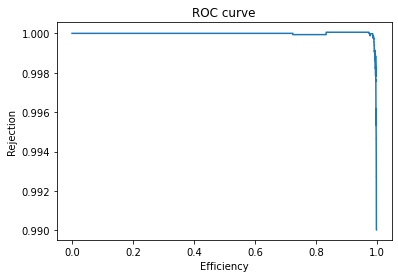

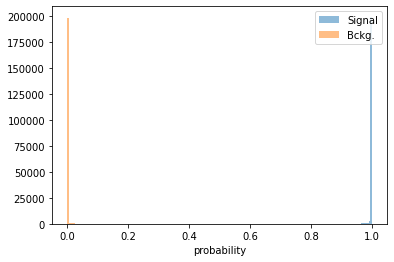

accuracy =  0.9971693899377677 , specificity =  0.9964950908890945 , sensitivity =  0.9978264726093579
-------------------------------------------
signal_mass =  2500
Number of ROC thresholds:  (357602,)
getAuc area & max(y):  0.999947868909249 1.0
auc =  0.999947868909249
getAuc area & max(y):  0.999947868909249 1.0


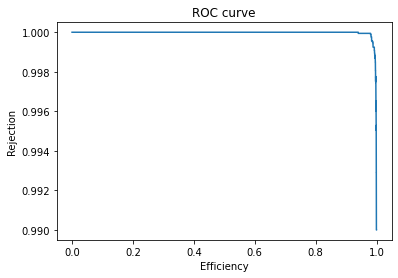

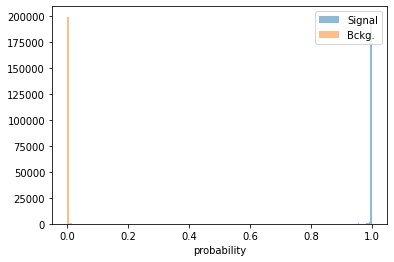

accuracy =  0.9972910278952362 , specificity =  0.997696973576799 , sensitivity =  0.9968763055132609
-------------------------------------------


In [ ]:
auc_list = []
av_auc_list = []
aucs_list = []

acc_list = []
spec_list = []
sens_list = []

for m in masses:


  print("signal_mass = ",m)
  mask = np.in1d(x_test_all.signal_mass, m)
  #mask = np.in1d(x_train_all.signal_mass, m)
  

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  #x_test_m = x_train_all[mask]
  #y_test_m = y_train_all[mask]
  #sw_test_m = sw_train_all[mask]

  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list.append(auc)
  av_auc_list.append(av_auc)
  aucs_list.append(aucs)

  accuracy, specificity, sensitivity = accuracy_ensamble(x_test_m, y_test_m, sw_test_m)
  acc_list.append(accuracy)
  spec_list.append(specificity)
  sens_list.append(sensitivity)
  
  print("-------------------------------------------")


Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

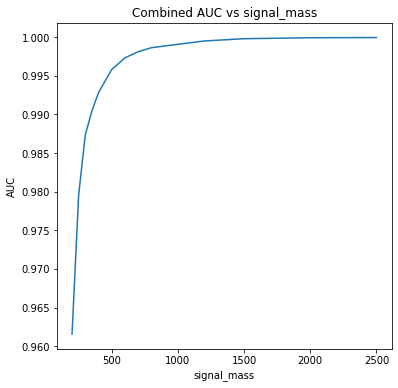

[0.961572241528892]


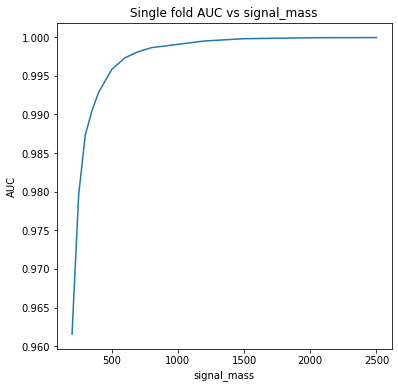

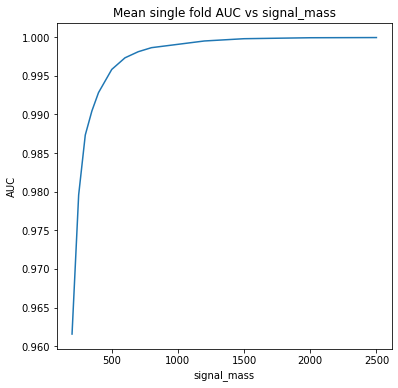

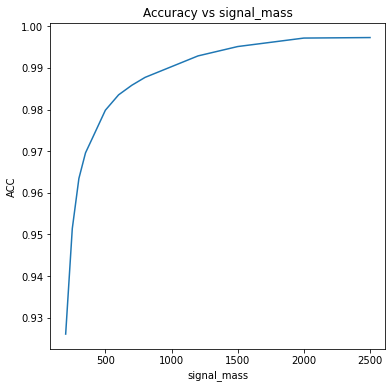

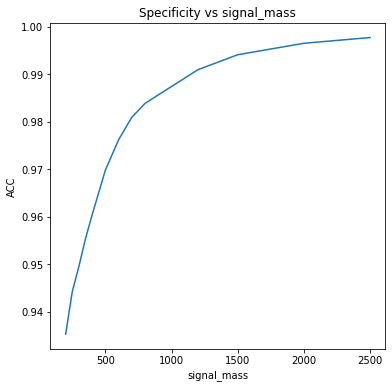

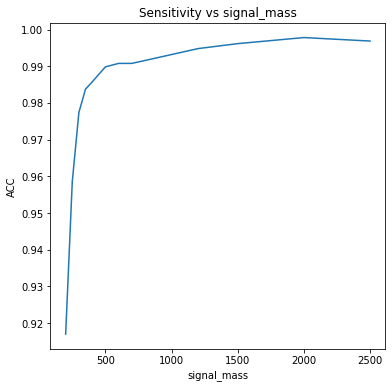

,signal_mass,comb. auc,mean auc,acc,specificity,sensitivity
0,200,0.961572,0.961572,0.926088,0.935301,0.917037
1,250,0.979578,0.979578,0.951411,0.944227,0.958618
2,300,0.987333,0.987333,0.963464,0.949551,0.977446
3,350,0.990446,0.990446,0.969608,0.955395,0.983773
4,400,0.992821,0.992821,0.973003,0.960396,0.985719
5,500,0.995820,0.995820,0.979843,0.969791,0.989835
6,600,0.997325,0.997325,0.983536,0.976199,0.990782
7,700,0.998115,0.998115,0.985839,0.980929,0.990789
8,800,0.998638,0.998638,0.987728,0.983852,0.991584
9,1200,0.999505,0.999505,0.992885,0.990945,0.994816


In [ ]:

plt.figure(figsize=(6,6))
plt.plot(masses, np.array(auc_list))
plt.title('Combined AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

print(aucs_list[0])

plt.figure(figsize=(6,6))
for i in range(len(aucs_list[0])):
  aux=[]
  for k in range(len(aucs_list)):
    aux.append(aucs_list[k][i])
  plt.plot(masses, np.array(aux))
plt.title('Single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(av_auc_list))
plt.title('Mean single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(acc_list))
plt.title('Accuracy vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(spec_list))
plt.title('Specificity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(sens_list))
plt.title('Sensitivity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list, acc_list, spec_list, sens_list)), 
               columns =['signal_mass', 'comb. auc', 'mean auc', 'acc', 'specificity', 'sensitivity']) 
aucf

Stop program execution

In [ ]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Split test data according to signal_mass, than train and test a network separately for each subsample. 

signal_mass =  200
fit_model
compiling
fitting
Epoch 1/100
5472/5472 [==============================] - 21s 4ms/step - loss: 0.2791 - auc: 0.8415 - lr: 9.9999e-05 - val_loss: 0.0939 - val_auc: 0.9609 - val_lr: 1.0000e-04
Epoch 2/100
5472/5472 [==============================] - 19s 3ms/step - loss: 0.1413 - auc: 0.9562 - lr: 9.0002e-05 - val_loss: 0.0867 - val_auc: 0.9646 - val_lr: 9.0000e-05
Epoch 3/100
5472/5472 [==============================] - 20s 4ms/step - loss: 0.1352 - auc: 0.9617 - lr: 8.1001e-05 - val_loss: 0.0895 - val_auc: 0.9671 - val_lr: 8.1000e-05
Epoch 4/100
5472/5472 [==============================] - 20s 4ms/step - loss: 0.1360 - auc: 0.9626 - lr: 7.2898e-05 - val_loss: 0.0803 - val_auc: 0.9672 - val_lr: 7.2900e-05
Epoch 5/100
5472/5472 [==============================] - 19s 3ms/step - loss: 0.1326 - auc: 0.9646 - lr: 6.5611e-05 - val_loss: 0.0861 - val_auc: 0.9643 - val_lr: 6.5610e-05
Epoch 6/100
5472/5472 [==============================] - 19s 4ms/step - loss: 0.132

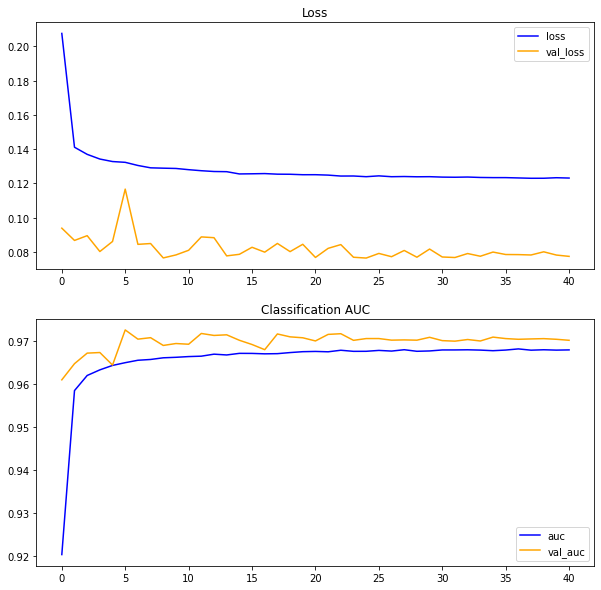

Accuracy: mean=19.436 std=0.000, n=1


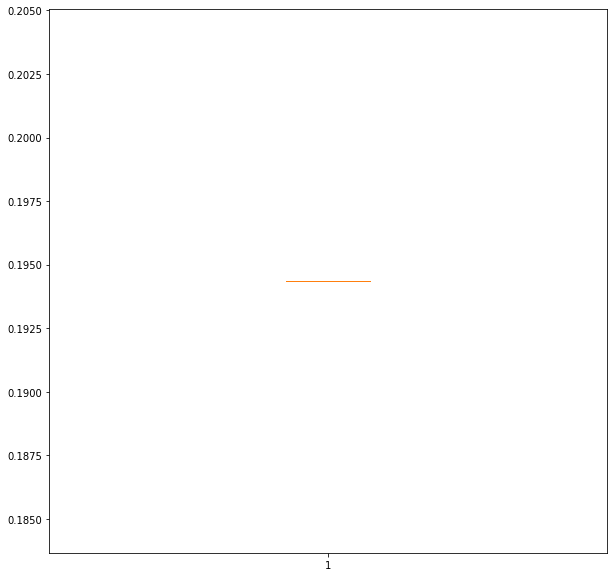

Scores:  [0.19435854256153107]
Number of ROC thresholds:  (600038,)
getAuc area & max(y):  0.9614625911811913 1.0
auc =  0.9614625911811913
getAuc area & max(y):  0.9614625911811913 1.0


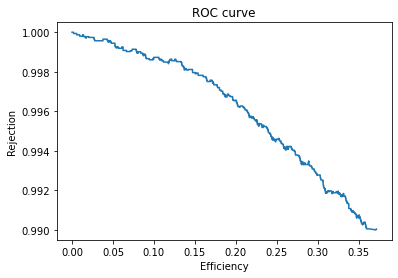

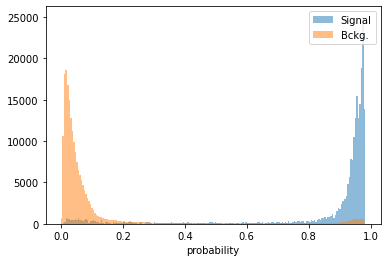

signal_mass =  250
fit_model
compiling
fitting
Epoch 1/100
5515/5515 [==============================] - 22s 4ms/step - loss: 0.2257 - auc: 0.8416 - lr: 9.9999e-05 - val_loss: 0.1001 - val_auc: 0.9527 - val_lr: 1.0000e-04
Epoch 2/100
5515/5515 [==============================] - 20s 4ms/step - loss: 0.1079 - auc: 0.9510 - lr: 9.0002e-05 - val_loss: 0.0924 - val_auc: 0.9474 - val_lr: 9.0000e-05
Epoch 3/100
5515/5515 [==============================] - 20s 4ms/step - loss: 0.0983 - auc: 0.9519 - lr: 8.1002e-05 - val_loss: 0.0888 - val_auc: 0.9481 - val_lr: 8.1000e-05
Epoch 4/100
5515/5515 [==============================] - 20s 4ms/step - loss: 0.0985 - auc: 0.9534 - lr: 7.2898e-05 - val_loss: 0.0870 - val_auc: 0.9553 - val_lr: 7.2900e-05
Epoch 5/100
5515/5515 [==============================] - 19s 4ms/step - loss: 0.0993 - auc: 0.9557 - lr: 6.5611e-05 - val_loss: 0.0883 - val_auc: 0.9522 - val_lr: 6.5610e-05
Epoch 6/100
5515/5515 [==============================] - 19s 4ms/step - loss: 0.098

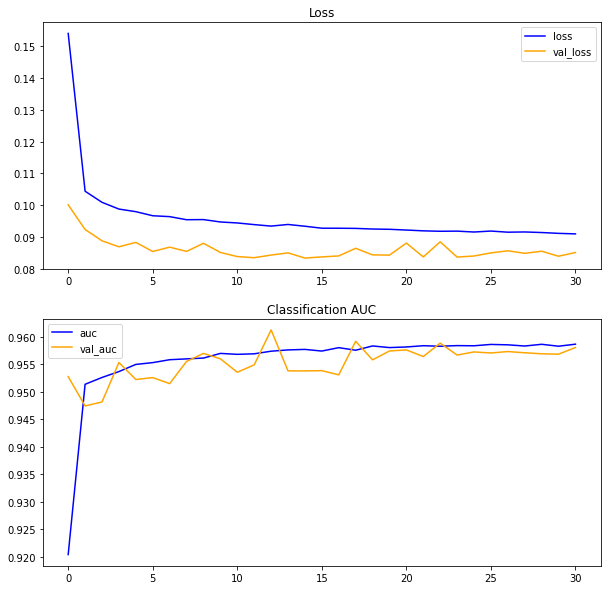

Accuracy: mean=32.920 std=0.000, n=1


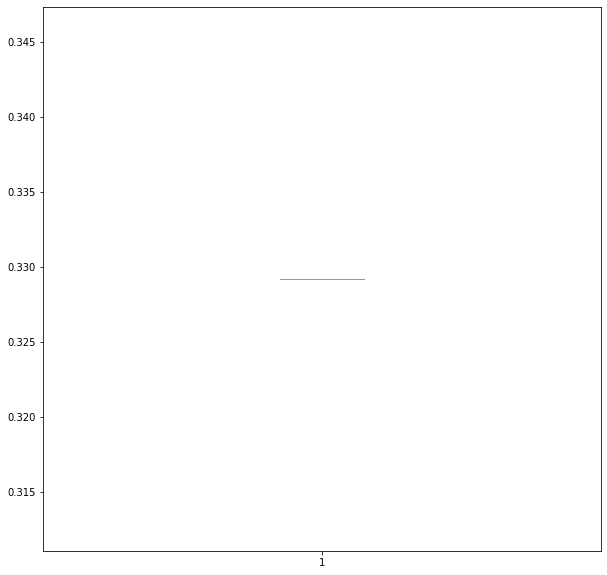

Scores:  [0.32919955253601074]
Number of ROC thresholds:  (619854,)
getAuc area & max(y):  0.9790096443838505 1.0000717989536134
auc =  0.9790096443838505
getAuc area & max(y):  0.9790096443838505 1.0000717989536134


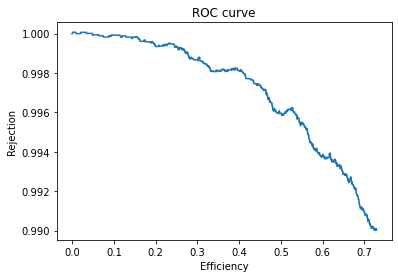

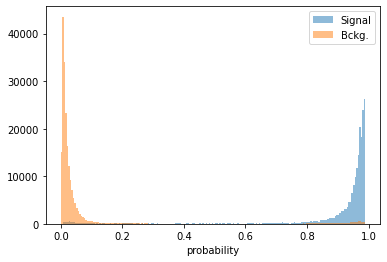

signal_mass =  300
fit_model
compiling
fitting
Epoch 1/100
5593/5593 [==============================] - 22s 4ms/step - loss: 0.1765 - auc: 0.8284 - lr: 9.9999e-05 - val_loss: 0.0721 - val_auc: 0.9367 - val_lr: 1.0000e-04
Epoch 2/100
5593/5593 [==============================] - 20s 4ms/step - loss: 0.0815 - auc: 0.9358 - lr: 9.0002e-05 - val_loss: 0.1295 - val_auc: 0.9239 - val_lr: 9.0000e-05
Epoch 3/100
5593/5593 [==============================] - 21s 4ms/step - loss: 0.0787 - auc: 0.9380 - lr: 8.1002e-05 - val_loss: 0.0716 - val_auc: 0.9435 - val_lr: 8.1000e-05
Epoch 4/100
5593/5593 [==============================] - 20s 4ms/step - loss: 0.0767 - auc: 0.9399 - lr: 7.2898e-05 - val_loss: 0.0682 - val_auc: 0.9374 - val_lr: 7.2900e-05
Epoch 5/100
5593/5593 [==============================] - 21s 4ms/step - loss: 0.0773 - auc: 0.9396 - lr: 6.5611e-05 - val_loss: 0.0676 - val_auc: 0.9413 - val_lr: 6.5610e-05
Epoch 6/100
5593/5593 [==============================] - 21s 4ms/step - loss: 0.072

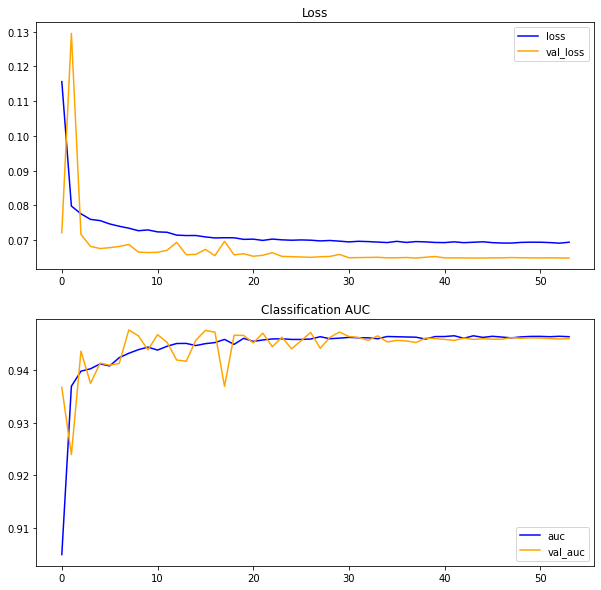

Accuracy: mean=44.236 std=0.000, n=1


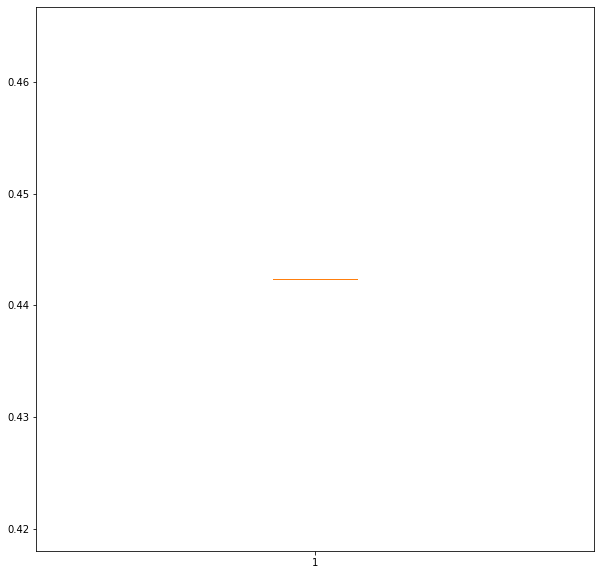

Scores:  [0.4423561096191406]
Number of ROC thresholds:  (603698,)
getAuc area & max(y):  0.9870280203056357 1.0000225061669739
auc =  0.9870280203056357
getAuc area & max(y):  0.9870280203056357 1.0000225061669739


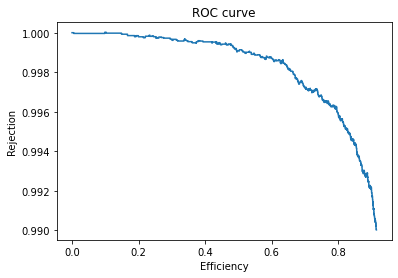

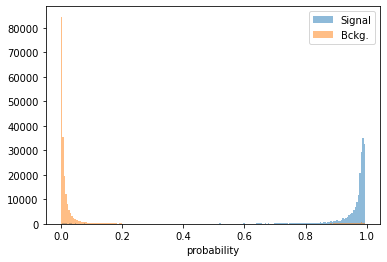

signal_mass =  350
fit_model
compiling
fitting
Epoch 1/100
5655/5655 [==============================] - 23s 4ms/step - loss: 0.1381 - auc: 0.8066 - lr: 9.9999e-05 - val_loss: 0.1359 - val_auc: 0.8888 - val_lr: 1.0000e-04
Epoch 2/100
5655/5655 [==============================] - 22s 4ms/step - loss: 0.0698 - auc: 0.9208 - lr: 9.0002e-05 - val_loss: 0.0662 - val_auc: 0.9233 - val_lr: 9.0000e-05
Epoch 3/100
5655/5655 [==============================] - 21s 4ms/step - loss: 0.0639 - auc: 0.9262 - lr: 8.1002e-05 - val_loss: 0.0707 - val_auc: 0.9306 - val_lr: 8.1000e-05
Epoch 4/100
5655/5655 [==============================] - 22s 4ms/step - loss: 0.0637 - auc: 0.9265 - lr: 7.2898e-05 - val_loss: 0.0712 - val_auc: 0.9356 - val_lr: 7.2900e-05
Epoch 5/100
5655/5655 [==============================] - 21s 4ms/step - loss: 0.0628 - auc: 0.9295 - lr: 6.5611e-05 - val_loss: 0.0673 - val_auc: 0.9150 - val_lr: 6.5610e-05
Epoch 6/100
5655/5655 [==============================] - 21s 4ms/step - loss: 0.060

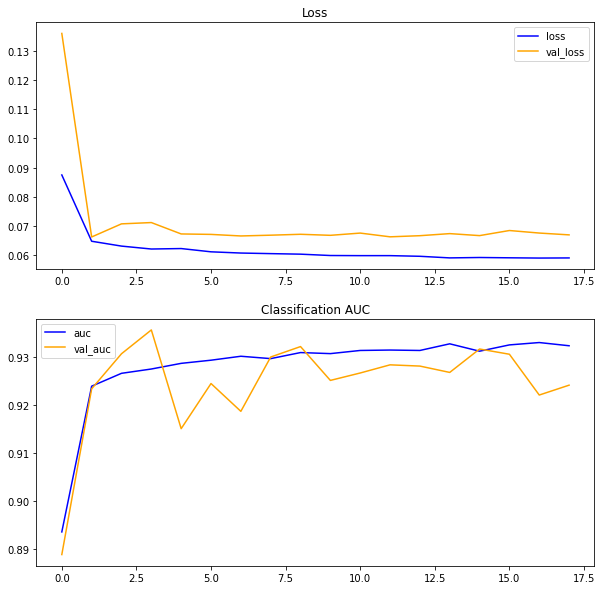

Accuracy: mean=65.776 std=0.000, n=1


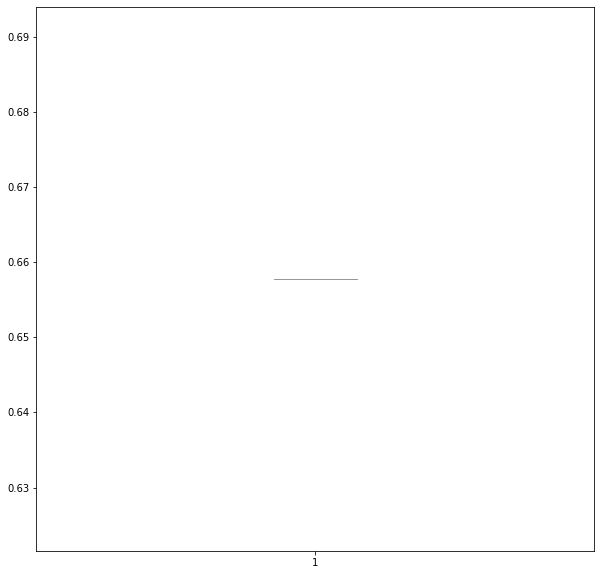

Scores:  [0.6577642560005188]
Number of ROC thresholds:  (695584,)
getAuc area & max(y):  0.9897392669461444 1.0
auc =  0.9897392669461444
getAuc area & max(y):  0.9897392669461444 1.0


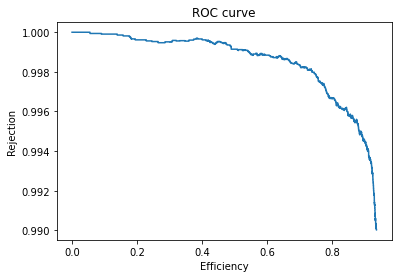

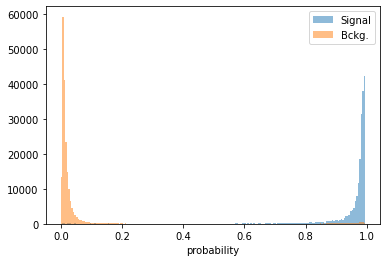

signal_mass =  400
fit_model
compiling
fitting
Epoch 1/100
5691/5691 [==============================] - 24s 4ms/step - loss: 0.1247 - auc: 0.7820 - lr: 9.9999e-05 - val_loss: 0.0620 - val_auc: 0.9018 - val_lr: 1.0000e-04
Epoch 2/100
5691/5691 [==============================] - 23s 4ms/step - loss: 0.0540 - auc: 0.9046 - lr: 9.0002e-05 - val_loss: 0.0586 - val_auc: 0.9151 - val_lr: 9.0000e-05
Epoch 3/100
5691/5691 [==============================] - 22s 4ms/step - loss: 0.0523 - auc: 0.9111 - lr: 8.1002e-05 - val_loss: 0.0590 - val_auc: 0.9114 - val_lr: 8.1000e-05
Epoch 4/100
5691/5691 [==============================] - 22s 4ms/step - loss: 0.0525 - auc: 0.9119 - lr: 7.2898e-05 - val_loss: 0.0576 - val_auc: 0.9101 - val_lr: 7.2900e-05
Epoch 5/100
5691/5691 [==============================] - 22s 4ms/step - loss: 0.0493 - auc: 0.9133 - lr: 6.5611e-05 - val_loss: 0.0774 - val_auc: 0.9091 - val_lr: 6.5610e-05
Epoch 6/100
5691/5691 [==============================] - 22s 4ms/step - loss: 0.049

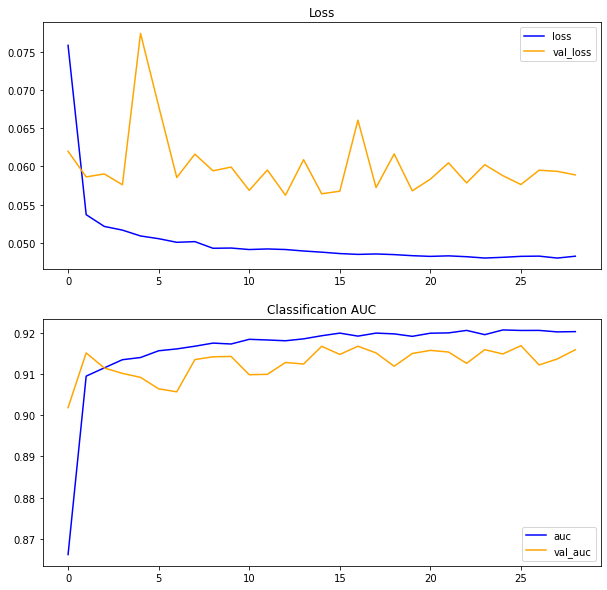

Accuracy: mean=76.752 std=0.000, n=1


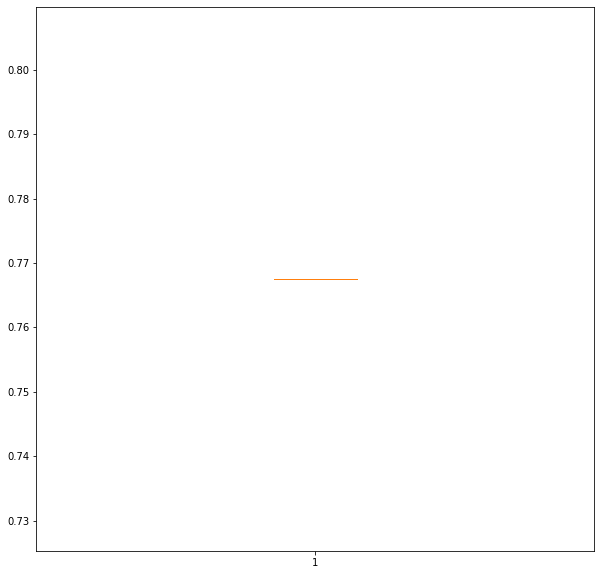

Scores:  [0.7675220370292664]
Number of ROC thresholds:  (665328,)
getAuc area & max(y):  0.9925684771398896 1.0
auc =  0.9925684771398896
getAuc area & max(y):  0.9925684771398896 1.0


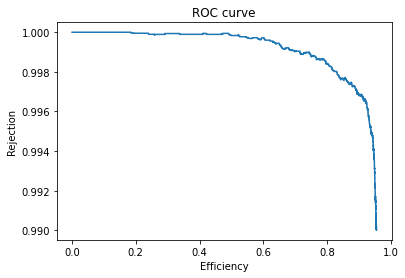

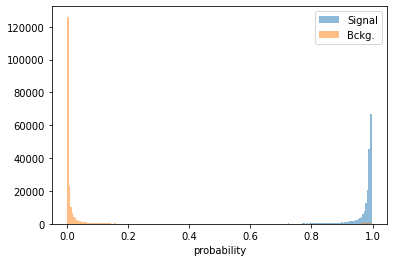

signal_mass =  500
fit_model
compiling
fitting
Epoch 1/100
5741/5741 [==============================] - 23s 4ms/step - loss: 0.1028 - auc: 0.7528 - lr: 9.9999e-05 - val_loss: 0.0229 - val_auc: 0.8926 - val_lr: 1.0000e-04
Epoch 2/100
5741/5741 [==============================] - 24s 4ms/step - loss: 0.0385 - auc: 0.8796 - lr: 9.0002e-05 - val_loss: 0.0218 - val_auc: 0.8821 - val_lr: 9.0000e-05
Epoch 3/100
5741/5741 [==============================] - 24s 4ms/step - loss: 0.0387 - auc: 0.8811 - lr: 8.1002e-05 - val_loss: 0.0205 - val_auc: 0.8970 - val_lr: 8.1000e-05
Epoch 4/100
5741/5741 [==============================] - 23s 4ms/step - loss: 0.0374 - auc: 0.8859 - lr: 7.2898e-05 - val_loss: 0.0191 - val_auc: 0.8972 - val_lr: 7.2900e-05
Epoch 5/100
5741/5741 [==============================] - 22s 4ms/step - loss: 0.0373 - auc: 0.8879 - lr: 6.5611e-05 - val_loss: 0.0203 - val_auc: 0.8954 - val_lr: 6.5610e-05
Epoch 6/100
5741/5741 [==============================] - 23s 4ms/step - loss: 0.036

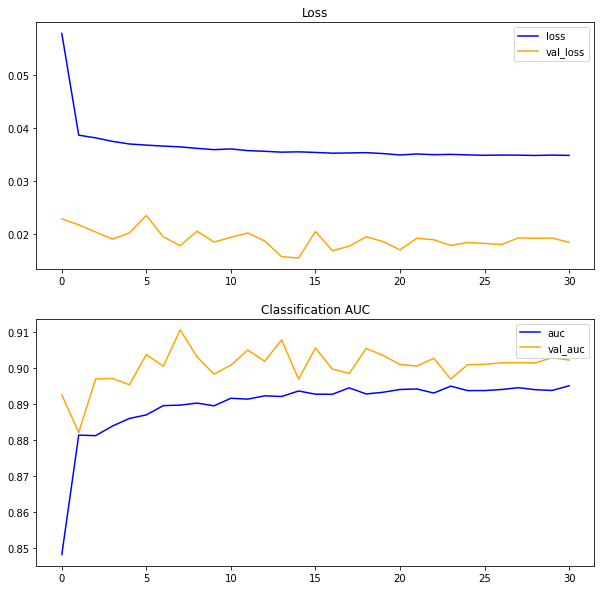

Accuracy: mean=98.702 std=0.000, n=1


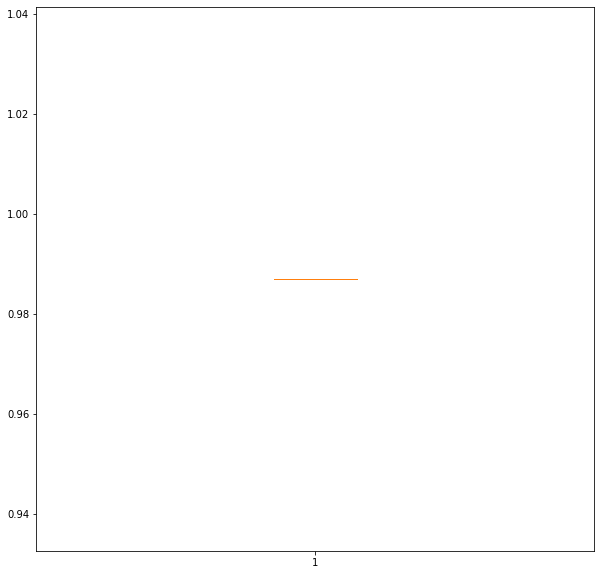

Scores:  [0.9870229959487915]
Number of ROC thresholds:  (634896,)
getAuc area & max(y):  0.9956744961848978 1.0
auc =  0.9956744961848978
getAuc area & max(y):  0.9956744961848978 1.0


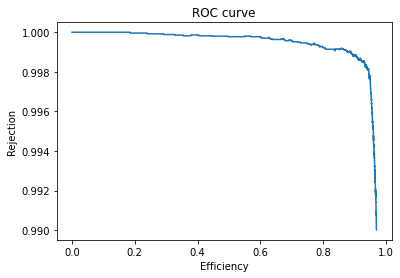

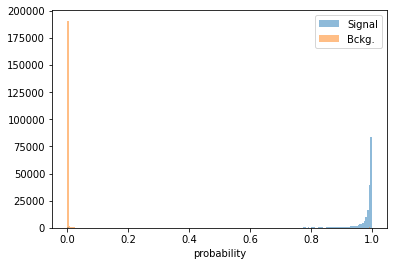

signal_mass =  600
fit_model
compiling
fitting
Epoch 1/100
5596/5596 [==============================] - 23s 4ms/step - loss: 0.0911 - auc: 0.7088 - lr: 9.9999e-05 - val_loss: 0.0231 - val_auc: 0.8653 - val_lr: 1.0000e-04
Epoch 2/100
5596/5596 [==============================] - 22s 4ms/step - loss: 0.0331 - auc: 0.8479 - lr: 9.0002e-05 - val_loss: 0.0216 - val_auc: 0.8527 - val_lr: 9.0000e-05
Epoch 3/100
5596/5596 [==============================] - 23s 4ms/step - loss: 0.0316 - auc: 0.8482 - lr: 8.1002e-05 - val_loss: 0.0216 - val_auc: 0.8578 - val_lr: 8.1000e-05
Epoch 4/100
5596/5596 [==============================] - 22s 4ms/step - loss: 0.0302 - auc: 0.8530 - lr: 7.2898e-05 - val_loss: 0.0199 - val_auc: 0.8742 - val_lr: 7.2900e-05
Epoch 5/100
5596/5596 [==============================] - 22s 4ms/step - loss: 0.0311 - auc: 0.8557 - lr: 6.5611e-05 - val_loss: 0.0197 - val_auc: 0.8740 - val_lr: 6.5610e-05
Epoch 6/100
5596/5596 [==============================] - 22s 4ms/step - loss: 0.030

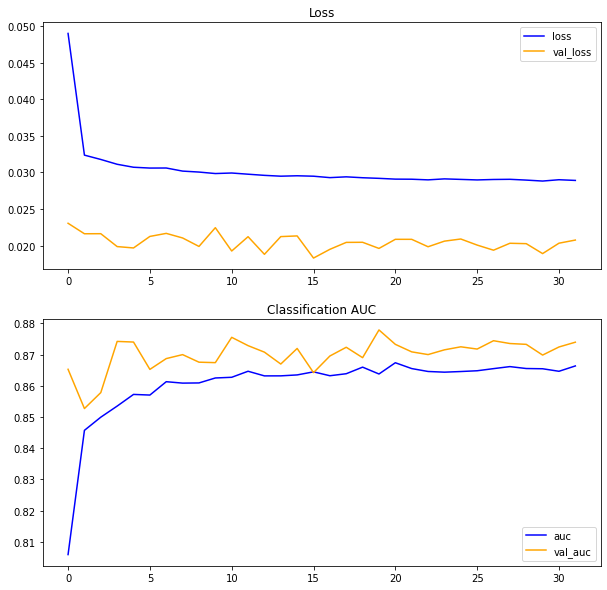

Accuracy: mean=145.339 std=0.000, n=1


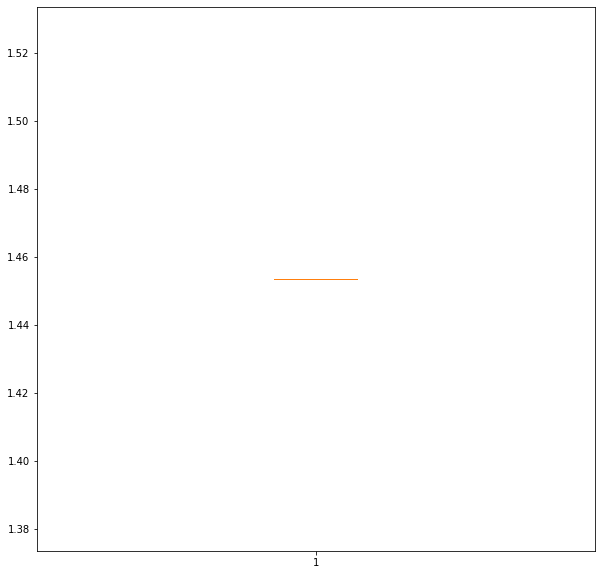

Scores:  [1.4533873796463013]
Number of ROC thresholds:  (593632,)
getAuc area & max(y):  0.9972171775755135 1.0000306306705775
auc =  0.9972171775755135
getAuc area & max(y):  0.9972171775755135 1.0000306306705775


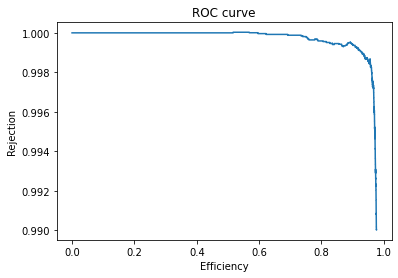

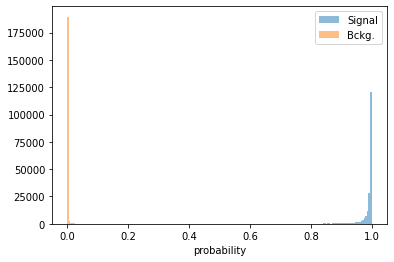

signal_mass =  700
fit_model
compiling
fitting
Epoch 1/100
5595/5595 [==============================] - 24s 4ms/step - loss: 0.0859 - auc: 0.6577 - lr: 9.9999e-05 - val_loss: 0.0446 - val_auc: 0.7895 - val_lr: 1.0000e-04
Epoch 2/100
5595/5595 [==============================] - 23s 4ms/step - loss: 0.0260 - auc: 0.7932 - lr: 9.0002e-05 - val_loss: 0.0373 - val_auc: 0.8039 - val_lr: 9.0000e-05
Epoch 3/100
5595/5595 [==============================] - 23s 4ms/step - loss: 0.0261 - auc: 0.7930 - lr: 8.1002e-05 - val_loss: 0.0364 - val_auc: 0.8343 - val_lr: 8.1000e-05
Epoch 4/100
5595/5595 [==============================] - 23s 4ms/step - loss: 0.0262 - auc: 0.8161 - lr: 7.2898e-05 - val_loss: 0.0361 - val_auc: 0.7969 - val_lr: 7.2900e-05
Epoch 5/100
5595/5595 [==============================] - 23s 4ms/step - loss: 0.0261 - auc: 0.8056 - lr: 6.5611e-05 - val_loss: 0.0394 - val_auc: 0.7998 - val_lr: 6.5610e-05
Epoch 6/100
5595/5595 [==============================] - 22s 4ms/step - loss: 0.025

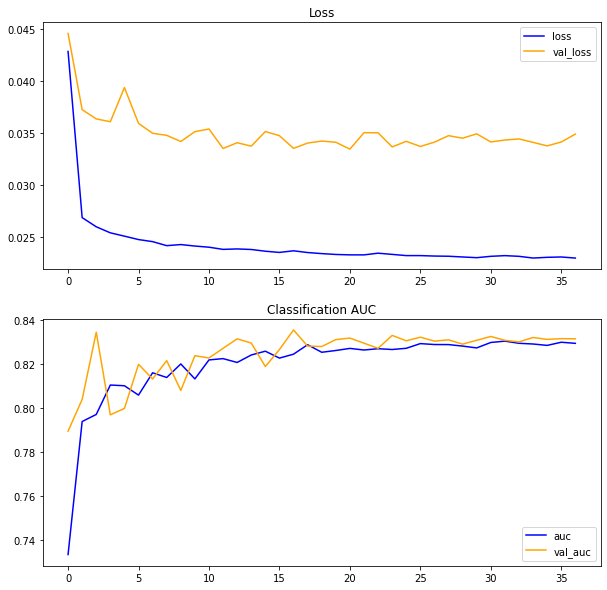

Accuracy: mean=209.783 std=0.000, n=1


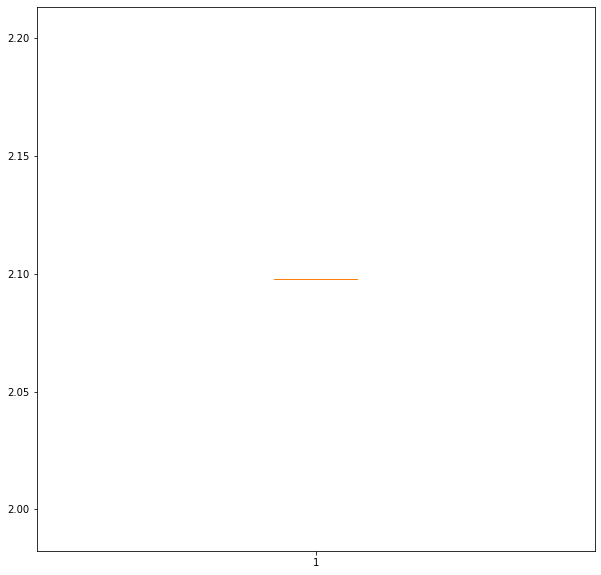

Scores:  [2.0978310108184814]
Number of ROC thresholds:  (552945,)
getAuc area & max(y):  0.9980676323536629 1.0
auc =  0.9980676323536629
getAuc area & max(y):  0.9980676323536629 1.0


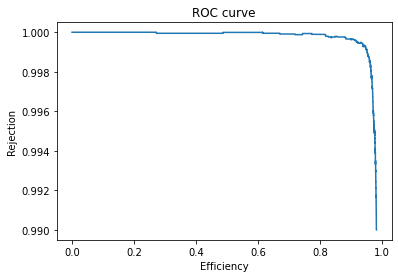

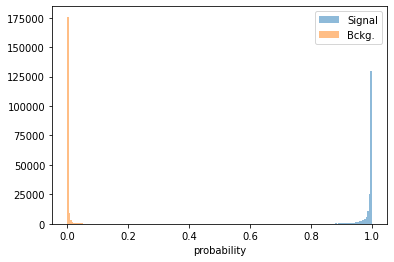

signal_mass =  800
fit_model
compiling
fitting
Epoch 1/100
5595/5595 [==============================] - 24s 4ms/step - loss: 0.0796 - auc: 0.5832 - lr: 9.9999e-05 - val_loss: 0.0187 - val_auc: 0.7769 - val_lr: 1.0000e-04
Epoch 2/100
5595/5595 [==============================] - 24s 4ms/step - loss: 0.0230 - auc: 0.7821 - lr: 9.0002e-05 - val_loss: 0.0183 - val_auc: 0.7849 - val_lr: 9.0000e-05
Epoch 3/100
5595/5595 [==============================] - 22s 4ms/step - loss: 0.0223 - auc: 0.7895 - lr: 8.1002e-05 - val_loss: 0.0179 - val_auc: 0.7796 - val_lr: 8.1000e-05
Epoch 4/100
5595/5595 [==============================] - 23s 4ms/step - loss: 0.0207 - auc: 0.7911 - lr: 7.2898e-05 - val_loss: 0.0158 - val_auc: 0.7943 - val_lr: 7.2900e-05
Epoch 5/100
5595/5595 [==============================] - 23s 4ms/step - loss: 0.0216 - auc: 0.7978 - lr: 6.5611e-05 - val_loss: 0.0156 - val_auc: 0.7883 - val_lr: 6.5610e-05
Epoch 6/100
5595/5595 [==============================] - 22s 4ms/step - loss: 0.021

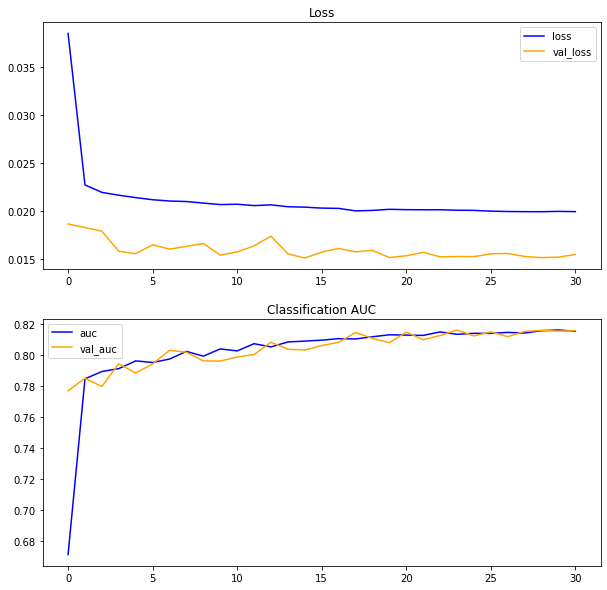

Accuracy: mean=246.912 std=0.000, n=1


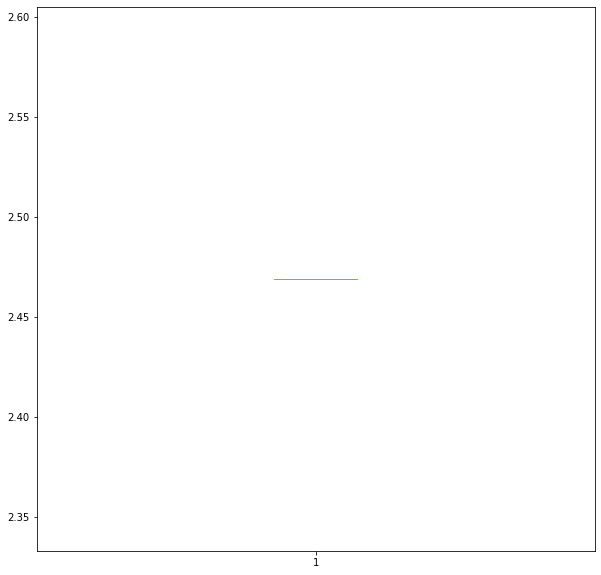

Scores:  [2.469122886657715]
Number of ROC thresholds:  (511405,)
getAuc area & max(y):  0.9986105182477071 1.0
auc =  0.9986105182477071
getAuc area & max(y):  0.9986105182477071 1.0


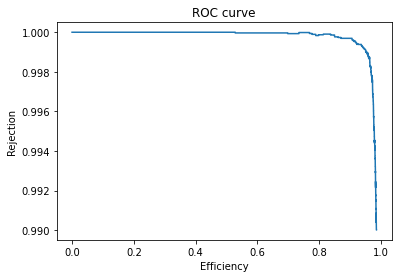

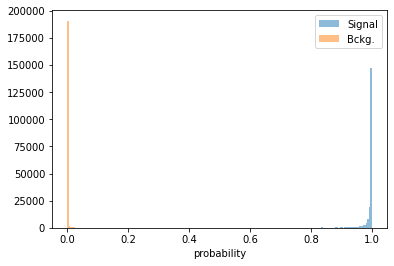

signal_mass =  1200
fit_model
compiling
fitting
Epoch 1/100
5477/5477 [==============================] - 25s 4ms/step - loss: 0.0617 - auc: 0.6191 - lr: 9.9999e-05 - val_loss: 0.0132 - val_auc: 0.6528 - val_lr: 1.0000e-04
Epoch 2/100
5477/5477 [==============================] - 23s 4ms/step - loss: 0.0160 - auc: 0.6432 - lr: 9.0002e-05 - val_loss: 0.0108 - val_auc: 0.6512 - val_lr: 9.0000e-05
Epoch 3/100
5477/5477 [==============================] - 23s 4ms/step - loss: 0.0159 - auc: 0.6507 - lr: 8.1001e-05 - val_loss: 0.0128 - val_auc: 0.6966 - val_lr: 8.1000e-05
Epoch 4/100
5477/5477 [==============================] - 24s 4ms/step - loss: 0.0147 - auc: 0.6899 - lr: 7.2898e-05 - val_loss: 0.0124 - val_auc: 0.6907 - val_lr: 7.2900e-05
Epoch 5/100
5477/5477 [==============================] - 23s 4ms/step - loss: 0.0147 - auc: 0.7054 - lr: 6.5611e-05 - val_loss: 0.0106 - val_auc: 0.7071 - val_lr: 6.5610e-05
Epoch 6/100
5477/5477 [==============================] - 24s 4ms/step - loss: 0.01

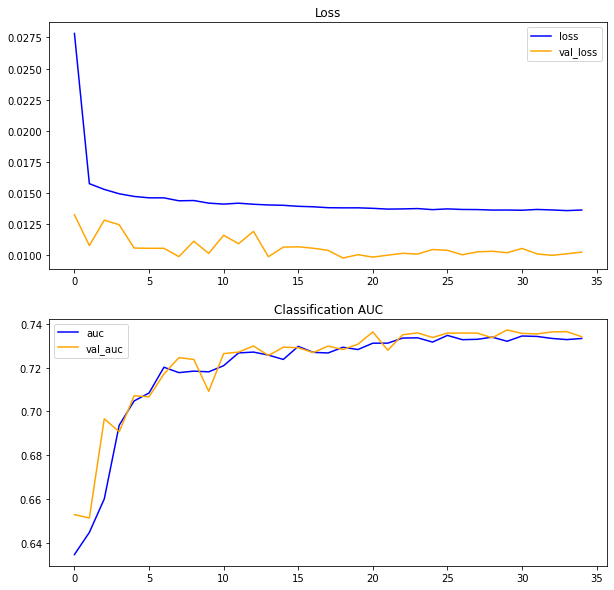

Accuracy: mean=411.164 std=0.000, n=1


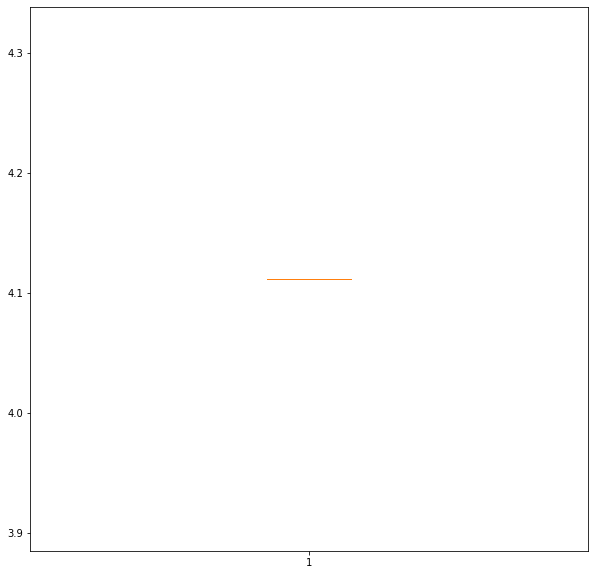

Scores:  [4.111635684967041]
Number of ROC thresholds:  (379461,)
getAuc area & max(y):  0.9994798296485524 1.0
auc =  0.9994798296485524
getAuc area & max(y):  0.9994798296485524 1.0


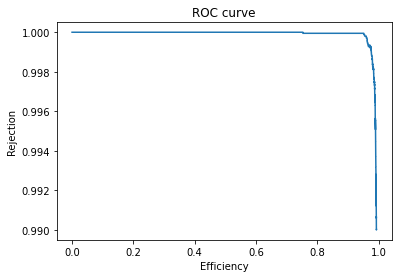

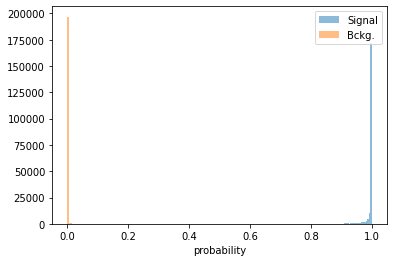

signal_mass =  1500
fit_model
compiling
fitting
Epoch 1/100
5392/5392 [==============================] - 25s 5ms/step - loss: 0.0528 - auc: 0.6569 - lr: 9.9999e-05 - val_loss: 0.0159 - val_auc: 0.6826 - val_lr: 1.0000e-04
Epoch 2/100
5392/5392 [==============================] - 24s 4ms/step - loss: 0.0108 - auc: 0.6810 - lr: 9.0002e-05 - val_loss: 0.0158 - val_auc: 0.6892 - val_lr: 9.0000e-05
Epoch 3/100
5392/5392 [==============================] - 25s 5ms/step - loss: 0.0077 - auc: 0.6824 - lr: 8.1001e-05 - val_loss: 0.0170 - val_auc: 0.6905 - val_lr: 8.1000e-05
Epoch 4/100
5392/5392 [==============================] - 24s 4ms/step - loss: 0.0093 - auc: 0.6837 - lr: 7.2898e-05 - val_loss: 0.0124 - val_auc: 0.6928 - val_lr: 7.2900e-05
Epoch 5/100
5392/5392 [==============================] - 24s 5ms/step - loss: 0.0091 - auc: 0.6854 - lr: 6.5611e-05 - val_loss: 0.0135 - val_auc: 0.6958 - val_lr: 6.5610e-05
Epoch 6/100
5392/5392 [==============================] - 24s 4ms/step - loss: 0.00

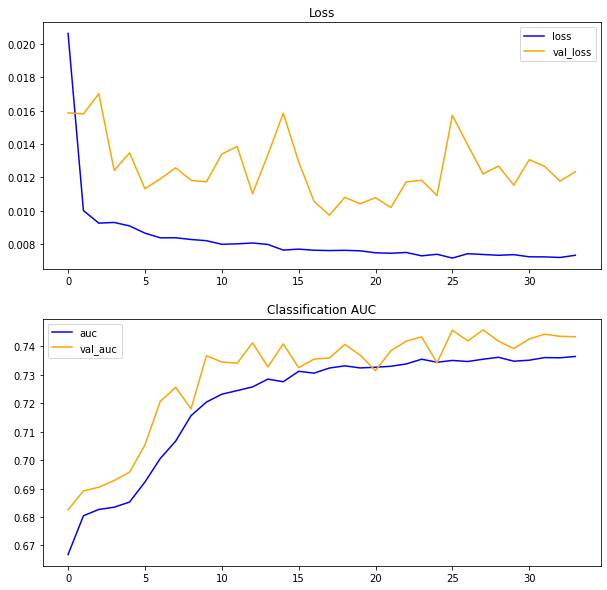

Accuracy: mean=461.905 std=0.000, n=1


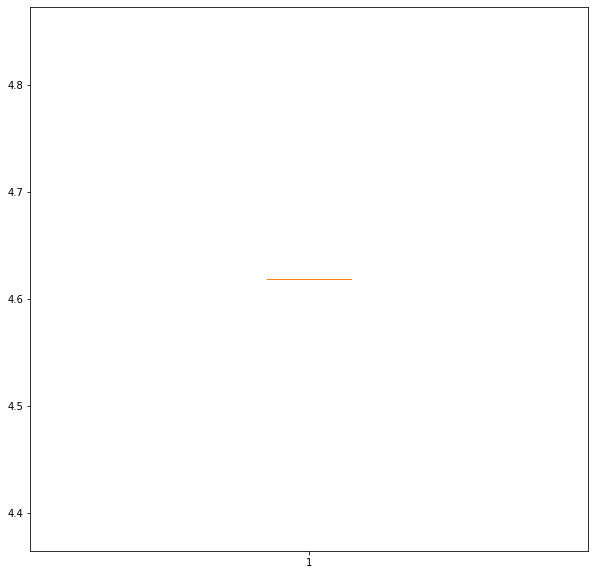

Scores:  [4.619053363800049]
Number of ROC thresholds:  (367935,)
getAuc area & max(y):  0.9997830484692224 1.0001069950161365
auc =  0.9997830484692224
getAuc area & max(y):  0.9997830484692224 1.0001069950161365


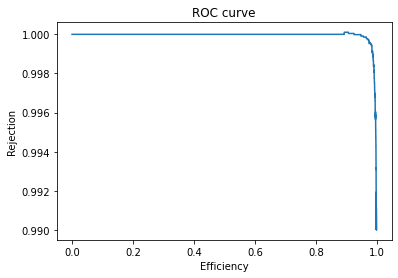

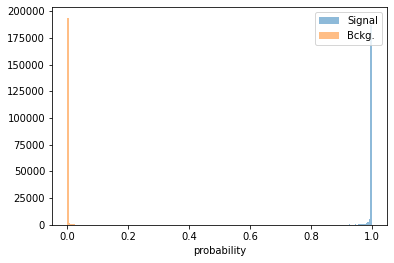

signal_mass =  2000
fit_model
compiling
fitting
Epoch 1/100
5348/5348 [==============================] - 25s 5ms/step - loss: 0.0427 - auc: 0.7023 - lr: 9.9999e-05 - val_loss: 0.0195 - val_auc: 0.6932 - val_lr: 1.0000e-04
Epoch 2/100
5348/5348 [==============================] - 25s 5ms/step - loss: 0.0072 - auc: 0.7062 - lr: 9.0002e-05 - val_loss: 0.0182 - val_auc: 0.7119 - val_lr: 9.0000e-05
Epoch 3/100
5348/5348 [==============================] - 24s 4ms/step - loss: 0.0078 - auc: 0.7143 - lr: 8.1001e-05 - val_loss: 0.0169 - val_auc: 0.7054 - val_lr: 8.1000e-05
Epoch 4/100
5348/5348 [==============================] - 23s 4ms/step - loss: 0.0065 - auc: 0.7163 - lr: 7.2898e-05 - val_loss: 0.0180 - val_auc: 0.7043 - val_lr: 7.2900e-05
Epoch 5/100
5348/5348 [==============================] - 24s 4ms/step - loss: 0.0063 - auc: 0.7194 - lr: 6.5611e-05 - val_loss: 0.0196 - val_auc: 0.6959 - val_lr: 6.5610e-05
Epoch 6/100
5348/5348 [==============================] - 23s 4ms/step - loss: 0.00

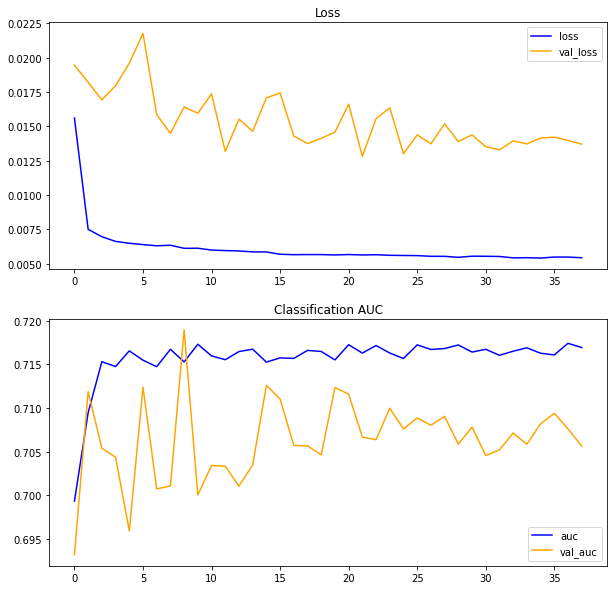

Accuracy: mean=572.554 std=0.000, n=1


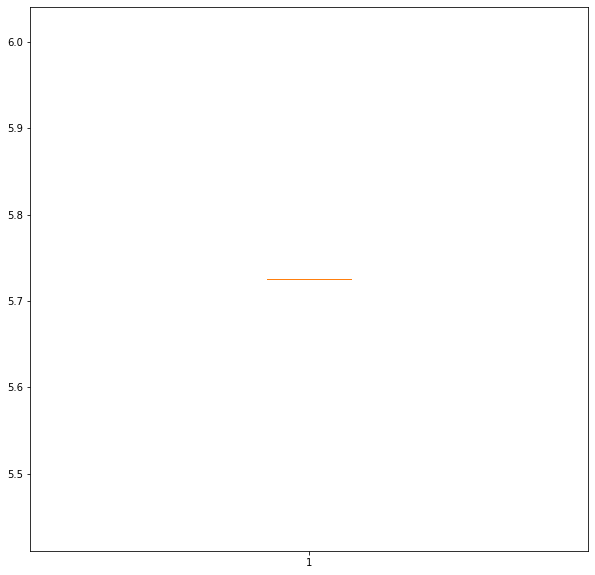

Scores:  [5.725542068481445]
Number of ROC thresholds:  (335776,)
getAuc area & max(y):  0.9999201671639116 1.000056588655858
auc =  0.9999201671639116
getAuc area & max(y):  0.9999201671639116 1.000056588655858


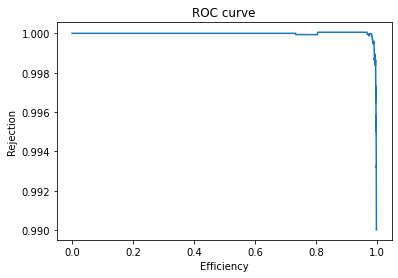

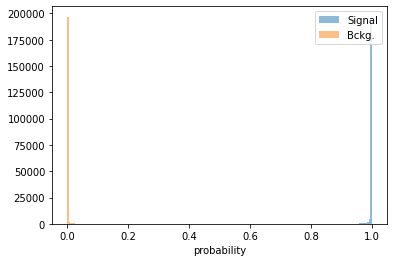

signal_mass =  2500
fit_model
compiling
fitting
Epoch 1/100
5318/5318 [==============================] - 27s 5ms/step - loss: 0.0419 - auc: 0.7273 - lr: 9.9999e-05 - val_loss: -0.0016 - val_auc: 0.7241 - val_lr: 1.0000e-04
Epoch 2/100
5318/5318 [==============================] - 24s 4ms/step - loss: 0.0060 - auc: 0.7244 - lr: 9.0002e-05 - val_loss: -9.6088e-04 - val_auc: 0.7424 - val_lr: 9.0000e-05
Epoch 3/100
5318/5318 [==============================] - 25s 5ms/step - loss: 0.0061 - auc: 0.7387 - lr: 8.1001e-05 - val_loss: -0.0043 - val_auc: 0.7320 - val_lr: 8.1000e-05
Epoch 4/100
5318/5318 [==============================] - 24s 5ms/step - loss: 0.0053 - auc: 0.7353 - lr: 7.2898e-05 - val_loss: -0.0013 - val_auc: 0.7335 - val_lr: 7.2900e-05
Epoch 5/100
5318/5318 [==============================] - 25s 5ms/step - loss: 0.0058 - auc: 0.7378 - lr: 6.5610e-05 - val_loss: -0.0015 - val_auc: 0.7383 - val_lr: 6.5610e-05
Epoch 6/100
5318/5318 [==============================] - 25s 5ms/step - l

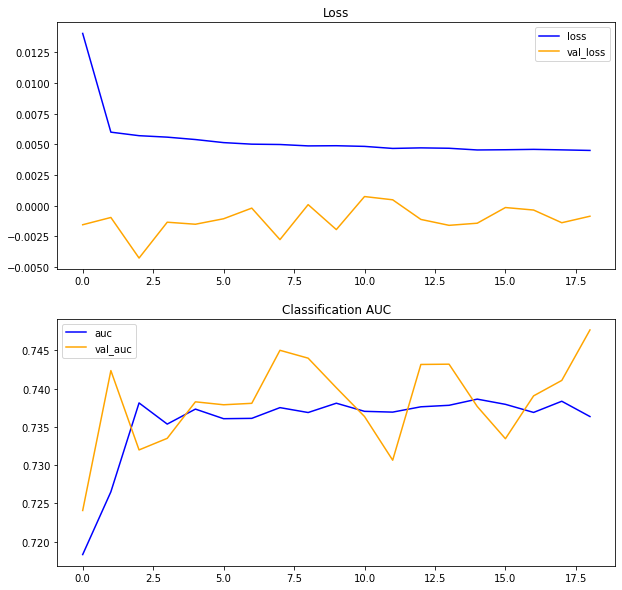

Accuracy: mean=724.288 std=0.000, n=1


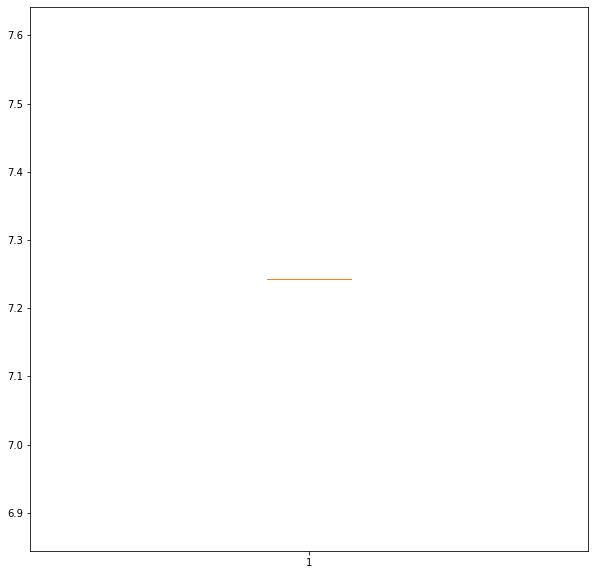

Scores:  [7.242884159088135]
Number of ROC thresholds:  (335232,)
getAuc area & max(y):  0.9999296781600628 1.0
auc =  0.9999296781600628
getAuc area & max(y):  0.9999296781600628 1.0


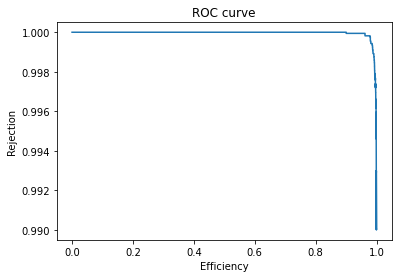

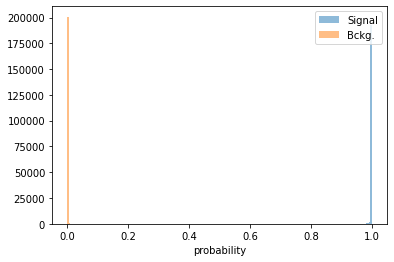

In [ ]:
auc_list_sep = []
av_auc_list_sep = []
aucs_list_sep = []


for m in masses:
  print("signal_mass = ",m)

  #select events with a given signal_mass from the training dataset...
  mask = np.in1d(x_train_all.signal_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[0].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list_sep.append(auc)
  av_auc_list_sep.append(av_auc)
  aucs_list_sep.append(aucs)
  

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

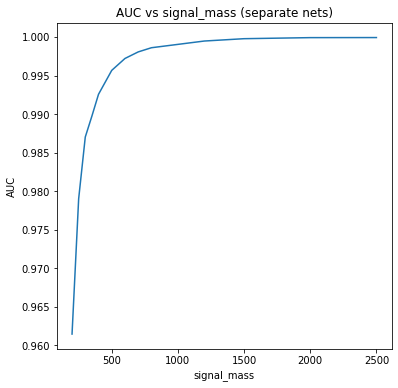

,signal_mass,comb. auc,mean auc
0,200,0.961463,0.961463
1,250,0.979010,0.979010
2,300,0.987028,0.987028
3,350,0.989739,0.989739
4,400,0.992568,0.992568
5,500,0.995674,0.995674
6,600,0.997217,0.997217
7,700,0.998068,0.998068
8,800,0.998611,0.998611
9,1200,0.999480,0.999480


In [ ]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()



# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep, av_auc_list_sep)), 
               columns =['signal_mass', 'comb. auc', 'mean auc']) 
aucf